In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1.

In [11]:
#read in data
mydata = pd.read_csv("hw12_data1.csv")
print(mydata)
xvals = mydata.x
yvals = mydata.y
yerror = mydata.y_err

            x  x_err         y     y_err
0    2.060000   0.02  0.686660  0.021769
1    2.860000   0.02  0.588802  0.009405
2    3.220000   0.02  0.557563  0.008566
3    4.060000   0.02  0.488122  0.007928
4    5.180000   0.02  0.437581  0.008504
5    6.060000   0.02  0.409972  0.009220
6    7.620000   0.02  0.374924  0.010801
7    9.860001   0.02  0.311528  0.012804
8   13.940001   0.02  0.285553  0.009549
9   24.100000   0.02  0.231378  0.003272
10  26.619999   0.02  0.210553  0.003722
11  28.060001   0.02  0.215938  0.004319
12  30.020000   0.02  0.202821  0.004781


# 2.

In [101]:
#turn our power function into a linear function
# y = C*x^alpah  -->  ln(y) = ln(C) + alpha*ln(x)
logys = np.log(yvals)
logxs = np.log(xvals)
logyerror = yerror/yvals #the error in y-value correlates to an error in ln(y)_err = y_err/y

In [102]:
coefs1, variance1 = np.polyfit(logxs, logys, 1, cov="unscaled")
#returns coefficients of 1st order polynomial, highest order first
#returns array of variance estimates (coef estimates on diagonal)
C1 = (np.e)**coefs1[1]
alpha1 = coefs1[0]
C_err1 = np.sqrt(np.diag(variance1)[1])
alpha_err1 = np.sqrt(np.diag(variance1)[0])

In [103]:
#create a pandas Data Frame to hold coefficients and errors
dataframe1 = pd.DataFrame({"Best_fit_C" : [C1],
                           "Best_fit_alpha" : [alpha1],
                           "C_error" : [C_err1],
                           "Alpha_error" : [alpha_err1]})
dataframe1.to_csv("data1_poly_fitresults.csv")
dataframe1

,Best_fit_C,Best_fit_alpha,C_error,Alpha_error
0,0.925548,-0.446233,0.712474,0.305302


In [150]:
#try using the y-errors now
coefs2, variance2 = np.polyfit(logxs, logys, 1, w=1/np.array(logyerror), cov="unscaled")
C2 = (np.e)**coefs2[1] #convert back into original C (not linearized C)
alpha2 = coefs2[0]

#convert ln(C) error back into just C error : ln(C)_err * C = C_err
C_err2 = (np.sqrt(np.diag(variance2)[1]))*C2
alpha_err2 = np.sqrt(np.diag(variance2)[0])


#create a pandas Data Frame to hold coefficients and errors
dataframe2 = pd.DataFrame({"Best_fit_C" : [C2],
                           "Best_fit_alpha" : [alpha2],
                           "C_error" : [C_err2],
                           "Alpha_error" : [alpha_err2]})
dataframe2.to_csv("data1_poly_fit_witherrs_results.csv")
print("Best_fit_C:", C2)
print("Best_fit_alpha:", alpha2)
print("C_error:", C_err2)
print("Alpha_error:", alpha_err2)
dataframe2

Best_fit_C: 0.9239525148835762
Best_fit_alpha: -0.442613128735659
C_error: 0.012520981320715493
Alpha_error: 0.005786551305200815


,Best_fit_C,Best_fit_alpha,C_error,Alpha_error
0,0.923953,-0.442613,0.012521,0.005787


When we convert the data into a linear model, we must also propogate the y-errors into our new linearization. In this case, when taking the ln(y), the new error's will be y_err/y_val. Then, using these new ln(y)_errors to inversely weight our polyfit model, we get similar coefficients, but the uncertianty in those coefficients is actually smaller (C_error: 0.712 vs 0.013, alpha_error: 0.305 vs 0.006). We get these smaller uncertainty's becuase poly_fit essentially has more "bounds" on what regression lines are possible when given the points' y-value errors.
However, to do this accurately, we need to know how to properly convert (or propogate) the original errors into our newly linearized data (which isn't always easy, since I had to look up the conversion for ln).

# 3.

In [113]:
#want curve_fit to return coefficients in alpha, C order (so input into the function in that order)
def function_to_fit(x,a,c):
    return c*(x**a)

In [114]:
coefs3, variance3 = curve_fit(function_to_fit, xvals, yvals, sigma=yerror, absolute_sigma=True)
C3 = coefs3[1]
alpha3 = coefs3[0]
C_err3 = np.sqrt(np.diag(variance3)[1])
alpha_err3 = np.sqrt(np.diag(variance3)[0])


In [115]:
#create a pandas Data Frame to hold coefficients and errors
dataframe3 = pd.DataFrame({"Best_fit_C" : [C3],
                           "Best_fit_alpha" : [alpha3],
                           "C_error" : [C_err3],
                           "Alpha_error" : [alpha_err3]})
dataframe3.to_csv("data1_curve_fitresults.csv")
dataframe3

,Best_fit_C,Best_fit_alpha,C_error,Alpha_error
0,0.923729,-0.442815,0.012583,0.005823


# 4.

In [138]:
x_sorted, y_sorted = zip(*sorted(zip(xvals, yvals)))

pf_model = C1*(x_sorted**alpha1)
cf_model = C3*(x_sorted**alpha3)

pf_residuals = y_sorted-pf_model
cf_residuals = y_sorted-cf_model

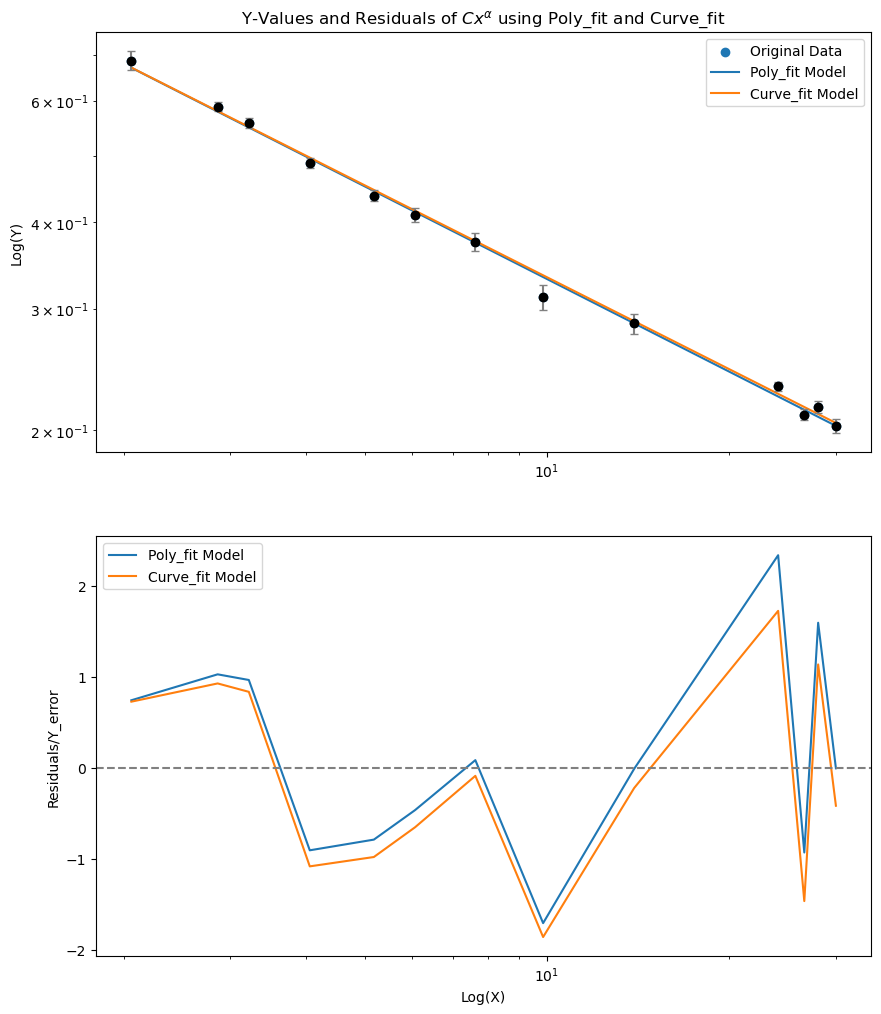

In [160]:
plt.figure(figsize=(10,12))

plt.subplot(211)
plt.scatter(x_sorted, y_sorted, label="Original Data")
plt.plot(x_sorted, pf_model, label="Poly_fit Model")
plt.plot(x_sorted, cf_model, label="Curve_fit Model")
plt.errorbar(x_sorted, y_sorted, yerr=yerror, fmt='o', color='black', ecolor='gray', capsize=3)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Log(Y)")


plt.title("Y-Values and Residuals of $Cx^α$ using Poly_fit and Curve_fit")
plt.legend()

plt.subplot(212)
plt.plot(x_sorted, pf_residuals/yerror, label="Poly_fit Model")
plt.plot(x_sorted, cf_residuals/yerror, label="Curve_fit Model")
plt.axhline(0, linestyle='--', c="gray")
plt.xscale("log")
plt.ylabel("Residuals/Y_error")
plt.xlabel("Log(X)")
plt.legend()
plt.show()

# 5.

In [155]:
#To figure out how "good" each model is, we need to calculate the chi^2 value 
#this is (residual/error)^2 for data with uncertainty
#we do this by squaring each residual/error for the model and then adding them all up
pf_reds_total = np.sum((pf_residuals/yerror)**2)
cf_reds_total = np.sum((cf_residuals/yerror)**2)

In [159]:
print("Chi^2 of Poly_fit Residuals:", pf_reds_total)
print("Chi^2 of Curve_fit Residuals:", cf_reds_total)

Chi^2 of Poly_fit Residuals: 16.01893598912334
Chi^2 of Curve_fit Residuals: 14.753044203679307


Looking at the graphs, the Y-values look nearly identical for the 2 best-fit models. The Residuals plot also looks nearly identical, with the Curve_fit model having slightly smaller residuals (but this also means more negative, so not always actually "less" residuals). 

But, looking at the calculated $\chi^2$ values, we can see that **Curve_fit** had the smaller value (14.75 < 16.02), meaning it had smaller residuals overall, making it the better model.